In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
import argparse
import os

In [ ]:
NUM_CLASS = 3
class_names = ['face_with_mask_correct', 'face_with_mask_incorrect', 'face_no_mask']
dataset_path = "/content/drive/MyDrive/face-mask-detect/Dataset/"

In [ ]:
LEARNING_RATE = 1e-4
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
data_generator = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    brightness_range=[0.3,0.9],
    preprocessing_function=preprocess_input,
    validation_split=0.2)

In [ ]:
train_generator = data_generator.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    subset='training')

Found 2297 images belonging to 3 classes.


In [ ]:
validation_generator = data_generator.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    subset='validation')

Found 573 images belonging to 3 classes.


In [ ]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
NUM_CLASS = 3
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(NUM_CLASS, activation="softmax")(head_model)

In [ ]:
model = Model(inputs=base_model.input, outputs=head_model)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

In [ ]:
checkpoint_filepath = "/content/drive/MyDrive/face-mask-detect/checkpoint1" "/epoch-{epoch:03d}-val_acc-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=False,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='auto')

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
  loss="categorical_crossentropy",
  metrics=["accuracy"])

In [ ]:
H = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    callbacks=[early_stopping, checkpoint],
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=EPOCHS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
71/71 [==============================] - 2315s 33s/step - loss: 1.0448 - accuracy: 0.5363 - val_loss: 0.3544 - val_accuracy: 0.8952
Epoch 2/20
71/71 [==============================] - 204s 3s/step - loss: 0.4190 - accuracy: 0.8505 - val_loss: 0.2527 - val_accuracy: 0.9173
Epoch 3/20
71/71 [==============================] - 204s 3s/step - loss: 0.2909 - accuracy: 0.8941 - val_loss: 0.2108 - val_accuracy: 0.9320
Epoch 4/20
71/71 [==============================] - 196s 3s/step - loss: 0.2485 - accuracy: 0.9120 - val_loss: 0.1867 - val_accuracy: 0.9283
Epoch 5/20
71/71 [==============================] - 197s 3s/step - loss: 0.2294 - accuracy: 0.9232 - val_loss: 0.1654 - val_accuracy: 0.9375
Epoch 6/20
71/71 [==============================] - 204s 3s/step - loss: 0.2000 - accuracy: 0.9186 - val_loss: 0.1437 - val_accuracy: 0.9393
Epoch 7/20
71/71 [==============================] - 200s 3s/step - loss: 0.1859 - accuracy: 0.9319 - val_loss: 0.1397 - val_accuracy: 0.9467
Epoch 8/20


In [ ]:
model.save("/content/drive/MyDrive/face-mask-detect/MFN_Model3.h5")

In [ ]:
prediction = model.predict_generator(
    generator=validation_generator,
    verbose=1)
y_pred = np.argmax(prediction, axis=1)
print("Classification Report:")
print(classification_report(validation_generator.classes, y_pred, target_names=class_names))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


18/18 [==============================] - 42s 2s/step
Classification Report:
                          precision    recall  f1-score   support

  face_with_mask_correct       0.95      0.96      0.96       192
face_with_mask_incorrect       0.96      0.95      0.96       191
            face_no_mask       1.00      1.00      1.00       190

                accuracy                           0.97       573
               macro avg       0.97      0.97      0.97       573
            weighted avg       0.97      0.97      0.97       573



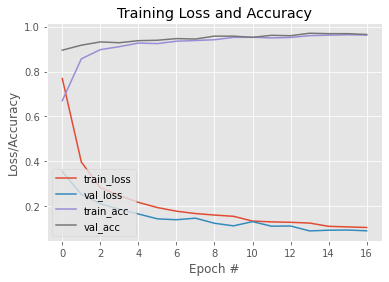

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(H.history["loss"])), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(H.history["val_loss"])), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, len(H.history["accuracy"])), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, len(H.history["val_accuracy"])), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(validation_generator, validation_generator.samples // validation_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(validation_generator.classes, y_pred)
print(cm)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[186   6   0]
 [ 10 181   0]
 [  0   0 190]]


Text(32.99999999999999, 0.5, 'True Labels')

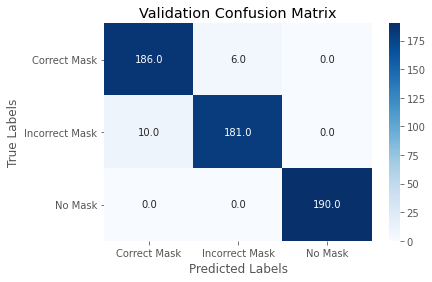

In [ ]:
import seaborn as sn
sn.heatmap(cm,annot=True,fmt = '.1f',xticklabels=['Correct Mask','Incorrect Mask','No Mask'],yticklabels=['Correct Mask','Incorrect Mask','No Mask'],cmap = 'Blues')
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(train_generator, train_generator.samples // train_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm1=confusion_matrix(train_generator.classes, y_pred)
print(cm1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[262 255 253]
 [257 249 258]
 [263 246 254]]


Text(32.99999999999999, 0.5, 'True Labels')

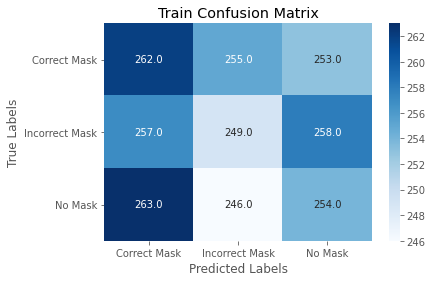

In [ ]:
import seaborn as sn
sn.heatmap(cm1,annot=True,fmt = '.1f',xticklabels=['Correct Mask','Incorrect Mask','No Mask'],yticklabels=['Correct Mask','Incorrect Mask','No Mask'],cmap = 'Blues')
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
val_steps=validation_generator.samples // validation_generator.batch_size
y_pred =  model.predict_generator(validation_generator, steps= val_steps)
fpr, tpr, tresholds = roc_curve(y_pred, validation_generator.classes)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


ValueError: ignored

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/face-mask-detect/MFN_Model3.h5')

In [17]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# fit model
clf = OneVsRestClassifier(LogisticRegression())
clf.fit_generator(train_generator)
pred = clf.predict_generator(train_generator)
pred_prob = clf.predict_proba(validation_generator)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(validation_generator, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    

AttributeError: ignored